In [1]:
#import necessary packages

#our workhorses
import numpy as np
import pandas as pd
import scipy

#to visualize
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
#style params for figures
sns.set(font_scale = 2)
plt.style.use('seaborn-white')
plt.rc("axes", labelweight="bold")
from IPython.display import display, HTML

#to load files
import os
import h5py

#for stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multitest as multitest
import statsmodels.stats.multicomp

#load custon functions
from utils import *

In [5]:
results_folder = './results_data/xsubject_joint_data/RNN'

results_df = []
for model_id in range(1,16):
    # load model results
    results_fn = 'model_%02d_results.h5'%(model_id)
    model_df = pd.read_hdf(os.path.join(results_folder,results_fn), 'results_df')
    model_df['Model'] = model_id
    #append to collective dataframe
    results_df.append(model_df)
results_df = pd.concat(results_df,axis = 0)

In [7]:
# Average over multiple train/test splits of the data
results_df = results_df.groupby(['Shuffled','Type','Model','Rep'],as_index = False)\
.mean()\
.drop(columns = ['Fold'])

In [8]:
results_df.head()

,Shuffled,Type,Model,Rep,F1_score
0,False,Test,1,1,0.820692
1,False,Test,1,2,0.828587
2,False,Test,1,3,0.810748
3,False,Test,1,4,0.805551
4,False,Test,1,5,0.804670


In [54]:
train_results_df = results_df.loc[results_df.Type == 'Train']
test_results_df = results_df.loc[results_df.Type == 'Test']

train_summary = train_results_df.groupby(['Shuffled','Model']).mean().\
drop(columns=['Rep']).\
rename(columns={'F1_score':'Train_score'})

test_summary = test_results_df.groupby(['Shuffled','Model']).mean().\
drop(columns=['Rep']).\
rename(columns={'F1_score':'Test_score'})

summary_df = pd.concat([train_summary,test_summary],axis = 1)
summary_df

Train_score  Test_score
Shuffled Model                         
False    1         0.944832    0.817078
         2         0.910592    0.815662
         3         0.892290    0.813455
         4         0.880494    0.811903
         5         0.910787    0.814137
         6         0.886025    0.810343
         7         0.850190    0.782311
         8         0.941032    0.815630
         9         0.930972    0.815061
         10        0.919980    0.809497
         11        0.930910    0.813283
         12        0.916479    0.809345
         13        0.729369    0.654149
         14        0.876023    0.800946
         15        0.654637    0.603202
True     1         0.280066    0.153221
         2         0.232619    0.145671
         3         0.213772    0.141515
         4         0.199042    0.138640
         5         0.251943    0.149545
         6         0.210249    0.132595
         7         0.156044    0.108977
         8         0.254495    0.145964
         9         0.228949    0.145876
         10        0.198546    0.135401
         11        0.249278    0.136930
         12        0.189908    0.118405
         13        0.142300    0.093483
         14        0.179354    0.129208
         15        0.120054    0.088556

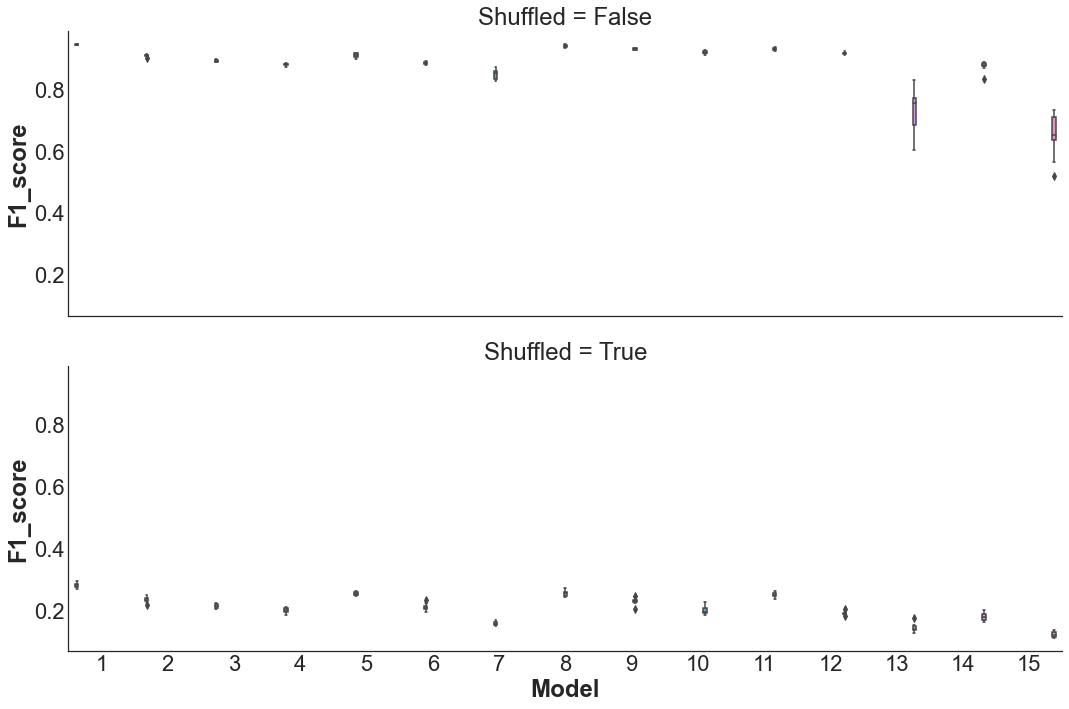

In [18]:


g = sns.catplot(data = train_results_df, x= 'Model', y = 'F1_score', col = 'Shuffled', hue = 'Model',\
            kind = 'box', col_order = [False,True], col_wrap = 1, aspect = 3)

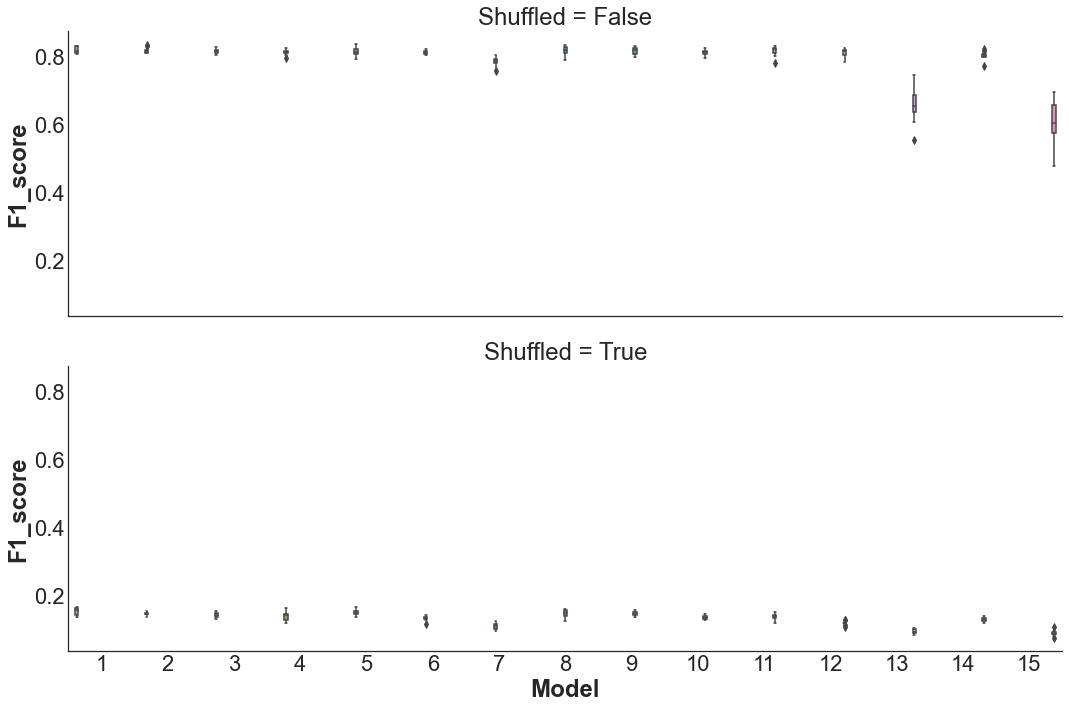

In [21]:
g = sns.catplot(data = test_results_df, x= 'Model', y = 'F1_score', col = 'Shuffled', hue = 'Model',\
            kind = 'box', col_order = [False,True], col_wrap = 1, aspect = 3)

In [47]:
results_true_df = results_df.loc[results_df.Shuffled == False]

In [49]:
# Run ANOVA
model = ols('F1_score ~ C(Model)*C(Type)', results_true_df).fit()

# Creates the ANOVA table
res = sm.stats.anova_lm(model, typ= 2)
res

,sum_sq,df,F,PR(>F)
C(Model),1.477116,14.0,162.355348,1.636410e-122
C(Type),0.642749,1.0,989.056832,2.922950e-92
C(Model):C(Type),0.040006,14.0,4.397251,4.477885e-07
Residual,0.175462,270.0,NaN,NaN


In [50]:
groups =  results_true_df['Model'].map(str) + ' - ' + results_true_df['Type'].map(str)

mc = statsmodels.stats.multicomp.MultiComparison(results_true_df['F1_score'],groups)
mc_results = mc.tukeyhsd()
print(mc_results)


    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1     group2   meandiff p-adj   lower   upper  reject
------------------------------------------------------------
  1 - Test  1 - Train   0.1278  0.001  0.0845   0.171   True
  1 - Test  10 - Test  -0.0076    0.9 -0.0508  0.0356  False
  1 - Test 10 - Train   0.1029  0.001  0.0597  0.1461   True
  1 - Test  11 - Test  -0.0038    0.9  -0.047  0.0394  False
  1 - Test 11 - Train   0.1138  0.001  0.0706   0.157   True
  1 - Test  12 - Test  -0.0077    0.9 -0.0509  0.0355  False
  1 - Test 12 - Train   0.0994  0.001  0.0562  0.1426   True
  1 - Test  13 - Test  -0.1629  0.001 -0.2061 -0.1197   True
  1 - Test 13 - Train  -0.0877  0.001 -0.1309 -0.0445   True
  1 - Test  14 - Test  -0.0161    0.9 -0.0593  0.0271  False
  1 - Test 14 - Train   0.0589  0.001  0.0157  0.1022   True
  1 - Test  15 - Test  -0.2139  0.001 -0.2571 -0.1707   True
  1 - Test 15 - Train  -0.1624  0.001 -0.2057 -0.1192   True
  1 - Test   2 - Test  -

In [44]:
test_results_true_df = results_df.loc[(results_df.Type == 'Test')&(results_df.Shuffled == False)]
train_results_true_df = results_df.loc[(results_df.Type == 'Train')&(results_df.Shuffled == False)]


In [45]:
# Run ANOVA
model = ols('F1_score ~ C(Model)', train_results_true_df).fit()

# Creates the ANOVA table
res = sm.stats.anova_lm(model, typ= 2)
res

,sum_sq,df,F,PR(>F)
C(Model),0.924579,14.0,93.342832,3.704050e-62
Residual,0.095514,135.0,NaN,NaN


In [46]:
groups =  train_results_true_df['Model'].map(str) #+ ' - ' + test_results_true_df['Shuffled'].map(str)

mc = statsmodels.stats.multicomp.MultiComparison(train_results_true_df['F1_score'],groups)
mc_results = mc.tukeyhsd()
print(mc_results)

#p_values = psturng(np.abs(mc_results.meandiffs / mc_results.std_pairs), len(mc_results.groupsunique), mc_results.df_total)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     1     10  -0.0249  0.711  -0.066  0.0163  False
     1     11  -0.0139    0.9  -0.055  0.0272  False
     1     12  -0.0284 0.5271 -0.0695  0.0127  False
     1     13  -0.2155  0.001 -0.2566 -0.1744   True
     1     14  -0.0688  0.001 -0.1099 -0.0277   True
     1     15  -0.2902  0.001 -0.3313 -0.2491   True
     1      2  -0.0342 0.2204 -0.0753  0.0069  False
     1      3  -0.0525 0.0018 -0.0936 -0.0114   True
     1      4  -0.0643  0.001 -0.1054 -0.0232   True
     1      5   -0.034 0.2284 -0.0751  0.0071  False
     1      6  -0.0588  0.001 -0.0999 -0.0177   True
     1      7  -0.0946  0.001 -0.1357 -0.0535   True
     1      8  -0.0038    0.9 -0.0449  0.0373  False
     1      9  -0.0139    0.9  -0.055  0.0272  False
    10     11   0.0109    0.9 -0.0302   0.052  False
    10     12  -0.0035    0.9 -0.0446  0.0376 

In [64]:
#put things in dataframe and sort
summary_df.reset_index().loc[summary_df.reset_index().Shuffled == False].\
sort_values(by=['Train_score','Test_score'],ascending = False)#.reset_index().lo

,Shuffled,Model,Train_score,Test_score
0,False,1,0.944832,0.817078
7,False,8,0.941032,0.815630
8,False,9,0.930972,0.815061
10,False,11,0.930910,0.813283
9,False,10,0.919980,0.809497
11,False,12,0.916479,0.809345
4,False,5,0.910787,0.814137
1,False,2,0.910592,0.815662
2,False,3,0.892290,0.813455
5,False,6,0.886025,0.810343


<AxesSubplot:>

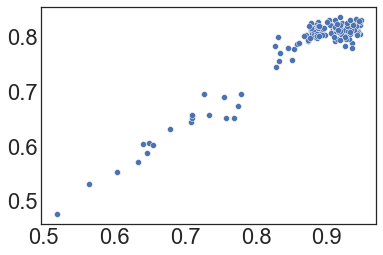

In [29]:
#checking correlaiton between train and test values - True data

X = results_df.loc[(results_df.Type == 'Train')&(results_df.Shuffled == False)]['F1_score'].values
Y = results_df.loc[(results_df.Type == 'Test')&(results_df.Shuffled == False)]['F1_score'].values

sns.scatterplot(x = X, y = Y)

<AxesSubplot:>

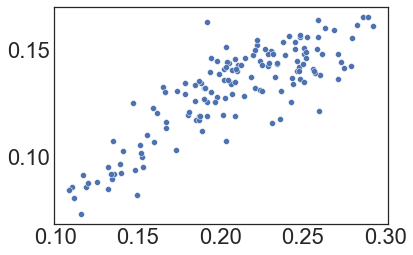

In [30]:
#checking correlaiton between train and test values - Shuffled data
X = results_df.loc[(results_df.Type == 'Train')&(results_df.Shuffled == True)]['F1_score'].values
Y = results_df.loc[(results_df.Type == 'Test')&(results_df.Shuffled == True)]['F1_score'].values

sns.scatterplot(x = X, y = Y)

In [ ]:
X = results_df.loc[(results_df.Type == 'Train')&(results_df.Type == 'Test')]